In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [3]:
import sys
LOCAL_FAST_AI = '/Users/krishnakalyan3/Educational/FastAI/fastai/'
AWS_FAST_AI = '/home/ubuntu/fastai'
sys.path.append(AWS_FAST_AI)

In [4]:
from fastai.transforms import * 
from fastai.conv_learner import * 
from fastai.model import *
from fastai.dataset import * 
from fastai.sgdr import *
from fastai.plots import *

In [5]:
PATH = '/home/ubuntu/Plant/data_seg/'

In [6]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n, val_pct=.02)
n, len(val_idxs)

(4750, 95)

In [7]:
torch.cuda.device_count()
#torch.cuda.set_device(7)
#torch.cuda.current_device()

8

In [8]:
f_model = resnet152
sz=250
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)

In [9]:
data = ImageClassifierData.from_csv(PATH, folder='train', csv_fname=f'{PATH}labels.csv',
                                    tfms=tfms, val_idxs=val_idxs, test_name='test', bs=64)

In [10]:
learn = ConvLearner.pretrained(f_model, data, precompute=True)
learn.models.model = torch.nn.DataParallel(learn.models.model,device_ids=list(range(0,8)))

A Jupyter Widget

 93%|█████████▎| 68/73 [00:01<00:00, 52.20it/s, loss=8.54]


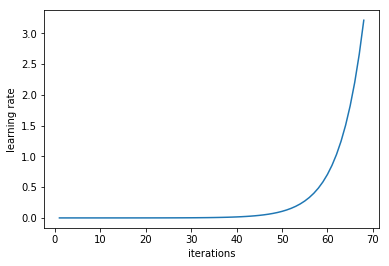

In [11]:
lrf=learn.lr_find()
learn.sched.plot_lr()

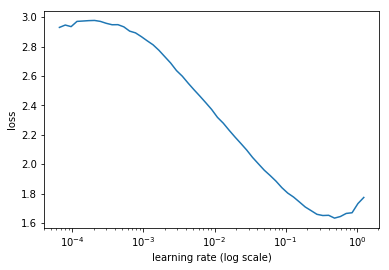

In [12]:
learn.sched.plot()

In [ ]:
learn.precompute=False
lr = 1e-1
learn.fit(lr, 3, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                 
    0      1.21921    0.341701   0.880796  
    1      0.90071    0.248327   0.896925                  
    2      0.76369    0.236737   0.921371                  



[0.23673698, 0.92137095332145691]

In [ ]:
learn.unfreeze()
lr=np.array([lr/18,lr/6,lr/2])
learn.fit(lr, 3, cycle_len=2, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                 
    0      1.182989   0.393378   0.825605  
    1      0.748909   0.202401   0.944304                  
    2      0.670639   0.235148   0.920363                  
    3      0.52943    0.182026   0.944304                  
    4      0.395643   0.116077   0.960433                  
    5      0.324676   0.114098   0.960433                  
 97%|█████████▋| 71/73 [01:07<00:01,  1.05it/s, loss=0.365]

In [ ]:
learn.save(f'resnet_152_{sz}')

# Training Accuracy

In [66]:
preds,y = learn.TTA()
mean_logpreds = np.mean(log_preds, 0)
max_preds = np.argmax(mean_logpreds, 1)

In [67]:
def metrics(y, yhat, plot=False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y, yhat)
    f1 = f1_score(y, yhat, average='macro')
    acc = accuracy_score(y, yhat)

    if plot:
        plt.matshow(cm)
    return f1, acc, cm

(0.99157088122605364,
 0.98947368421052628,
 array([[ 7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 15,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  0, 14,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  9,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8]]))

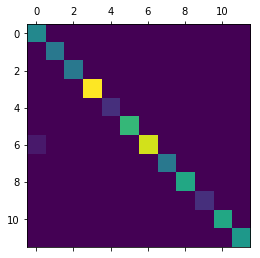

In [69]:
metrics(y, max_preds, True)

# Test Predictions

In [72]:
log_preds_test = learn.predict(is_test=True)
log_preds_test.shape

(794, 12)

In [75]:
max_preds = np.argmax(log_preds_test, 1)

In [78]:
preds_classes = [data.classes[i].replace("_", " ") for i in max_preds]
submission = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})
submission.to_csv(PATH + 'submission_resnet_152.csv', index=False)